# (gradually-increasing) Rotating MNIST
Diagonal online Laplace with a replay buffer v.s. diagonal LoFi

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from rebayes.utils.utils import get_subtree

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [3]:
kmode = "valid"
ksize = 100
kernel = np.ones(ksize) / ksize

## Hyperparameter optimisation

In [ ]:
%%time
%run rotating_mnist_unsorted.py increase

Training RSGD
Memory size: 1
|   iter    |  target   |  log_lr   |
-------------------------------------
| 1         | -2.201e+0 | -11.38    |
| 2         | -5.646e+0 | -9.025    |
| 3         | -7.287e+0 | -7.787    |
| 4         | -1.199e+0 | -14.96    |
| 5         | -1.508e+0 | -14.28    |
| 6         | -1.209e+0 | -14.94    |
| 7         | -3.401e+0 | -10.72    |
| 8         | -3.076e+0 | -10.91    |
| 9         | -7.159e+0 | -7.556    |
| 10        | -7.134e+0 | -7.592    |
| 11        | -5.904e+0 | -12.82    |
| 12        | -1.324e+0 | -13.41    |
| 13        | -4.744e+0 | -12.24    |
| 14        | -3.89e+03 | -12.51    |
| 15        | -3.925e+0 | -12.39    |
| 16        | -3.848e+0 | -12.46    |
| 17        | -3.847e+0 | -12.46    |
| 18        | -3.847e+0 | -12.46    |
| 19        | -3.847e+0 | -12.46    |
| 20        | -3.847e+0 | -12.46    |
| 21        | -3.847e+0 | -12.46    |
| 22        | -3.848e+0 | -12.45    |
| 23        | -3.852e+0 | -12.47    |
| 24        | -3.85e+

## Building agent

In [8]:
%%time
agents = {}

for memory, optimiser_rsgd in rsgd_optimisers.items( ):
    lr = np.exp(optimiser_rsgd.max["params"]["log_lr"])
    tx = optax.sgd(lr)

    agent_rsgd = rsgd.init_regression_agent(
        key, part_log_likelihood, model, X_train, tx, memory_size,
        lossfn=part_lossfn,
        prior_precision=1 / initial_covariance,
    )
    
    agents[f"r-sgd-{memory:02}"] = agent_rsgd

for memory, optimiser_adam in adam_optimisers.items():
    lr = np.exp(optimiser_adam.max["params"]["log_lr"])
    tx = optax.adam(lr)

    agent_adam = rsgd.init_regression_agent(
        key, part_log_likelihood, model, X_train, tx, memory_size,
        lossfn=part_lossfn,
        prior_precision=1 / initial_covariance,
    )
    
    agents[f"r-adam-{memory:02}"] = agent_adam

for memory, optimiser_lofi in lofi_optimisers.items():
    dynamics_covariance = np.exp(optimiser_lofi.max["params"]["log_dynamics_covariance"])
    dynamics_weights = 1 - np.exp(optimiser_lofi.max["params"]["log_1m_dynamics_weights"])

    agent_lofi, rfn = lofi.init_regression_agent(
        key, model, X_train,
        initial_covariance, dynamics_weights, dynamics_covariance,
        emission_cov, memory_size
    )
    agents[f"lofi-{memory:02}"] = agent_lofi

CPU times: user 686 ms, sys: 75.5 ms, total: 761 ms
Wall time: 543 ms


## Run agents

In [9]:
callback = partial(callbacks.cb_reg_mc,
                ymean=ymean, ystd=ystd,
                X_test=X_train, y_test=Y_train,
                key=key,
)

In [10]:
%%time
outputs = {}
bel_agents = {}

for name_agent, agent in agents.items():
    print(name_agent)
    if "lofi" in name_agent:
        applyfn = agent.params.emission_mean_function
    else:
        applyfn = agent.apply_fn
        
    callback_agent = partial(callback, apply_fn=applyfn, agent=agent)
    bel_agent, output_agent = agent.scan(X_train, Y_train, progress_bar=True, callback=callback_agent)
    output_agent = tree_to_cpu(output_agent)
    
    outputs[name_agent] = output_agent
    bel_agents[name_agent] = bel_agent

r-sgd-01


  0%|          | 0/5458 [00:00<?, ?it/s]

r-sgd-05


  0%|          | 0/5458 [00:00<?, ?it/s]

r-sgd-10


  0%|          | 0/5458 [00:00<?, ?it/s]

r-adam-01


  0%|          | 0/5458 [00:00<?, ?it/s]

r-adam-05


  0%|          | 0/5458 [00:00<?, ?it/s]

r-adam-10


  0%|          | 0/5458 [00:00<?, ?it/s]

lofi-05


  0%|          | 0/5458 [00:00<?, ?it/s]

lofi-10


  0%|          | 0/5458 [00:00<?, ?it/s]

lofi-20


  0%|          | 0/5458 [00:00<?, ?it/s]

lofi-50


  0%|          | 0/5458 [00:00<?, ?it/s]

CPU times: user 6min 46s, sys: 13.1 s, total: 6min 59s
Wall time: 13min 24s


## Store outputs

In [51]:
dir_output = "../../figures/"
task_name = "inv-damp-rotation"

In [27]:
import os
import pickle

path_base = f"../../outputs/gradually-rotating-reg"
path_target = os.path.join(path_base, f"{task_name}-outputs.pkl")
with open(path_target, "wb") as f:
    pickle.dump(outputs, f)

## Plot results

In [64]:
colors = {
    "lofi-05": plt.cm.Blues(0.3),
    "lofi-10": plt.cm.Blues(0.6),
    "lofi-20": plt.cm.Blues(0.8),
    "lofi-50": plt.cm.Blues(0.8),
    
    "r-adam-01": plt.cm.Reds(0.3),
    "r-adam-05": plt.cm.Reds(0.65),
    "r-adam-10": plt.cm.Reds(1.0),
    
    "r-sgd-01": plt.cm.Greens(0.3),
    "r-sgd-05": plt.cm.Greens(0.65),
    "r-sgd-10": plt.cm.Greens(1.0),    
}

### RMSE

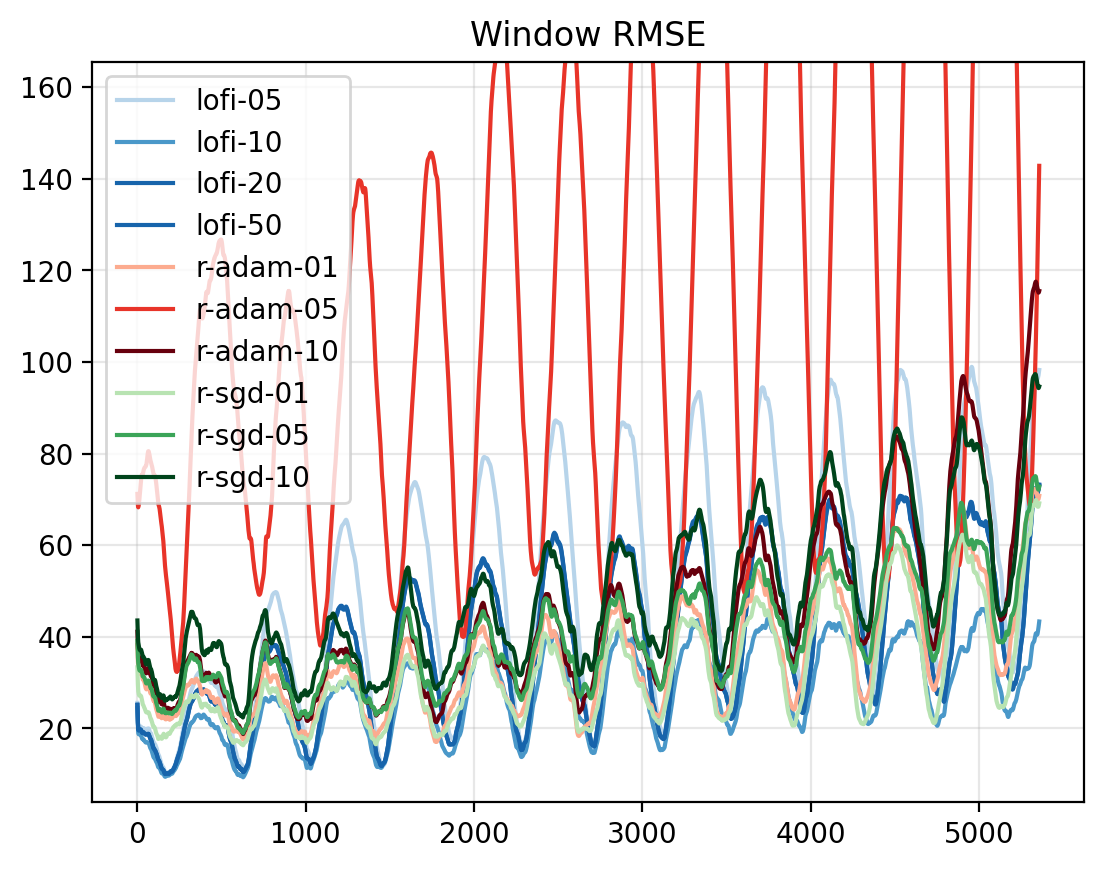

In [71]:
metric = "window-metric"
title = "Window RMSE"

outputs_metric = get_subtree(outputs, metric)
outputs_metric = jax.tree_map(lambda x: np.convolve(x, kernel, mode=kmode), outputs_metric)

for name_agent, metric_agent in outputs_metric.items():
    plt.plot(metric_agent, label=name_agent, c=colors[name_agent])

metric_agent = outputs["lofi-10"][metric]
vmin = np.quantile(metric_agent, 0.00)
vmax = np.quantile(metric_agent, 1.0)
plt.ylim(vmin, vmax)

plt.title(title)
plt.legend()
plt.grid(alpha=0.3)

namefile = f"window-rmse.pdf"
namefile = os.path.join(dir_output, f"{task_name}-{namefile}")
plt.savefig(namefile)

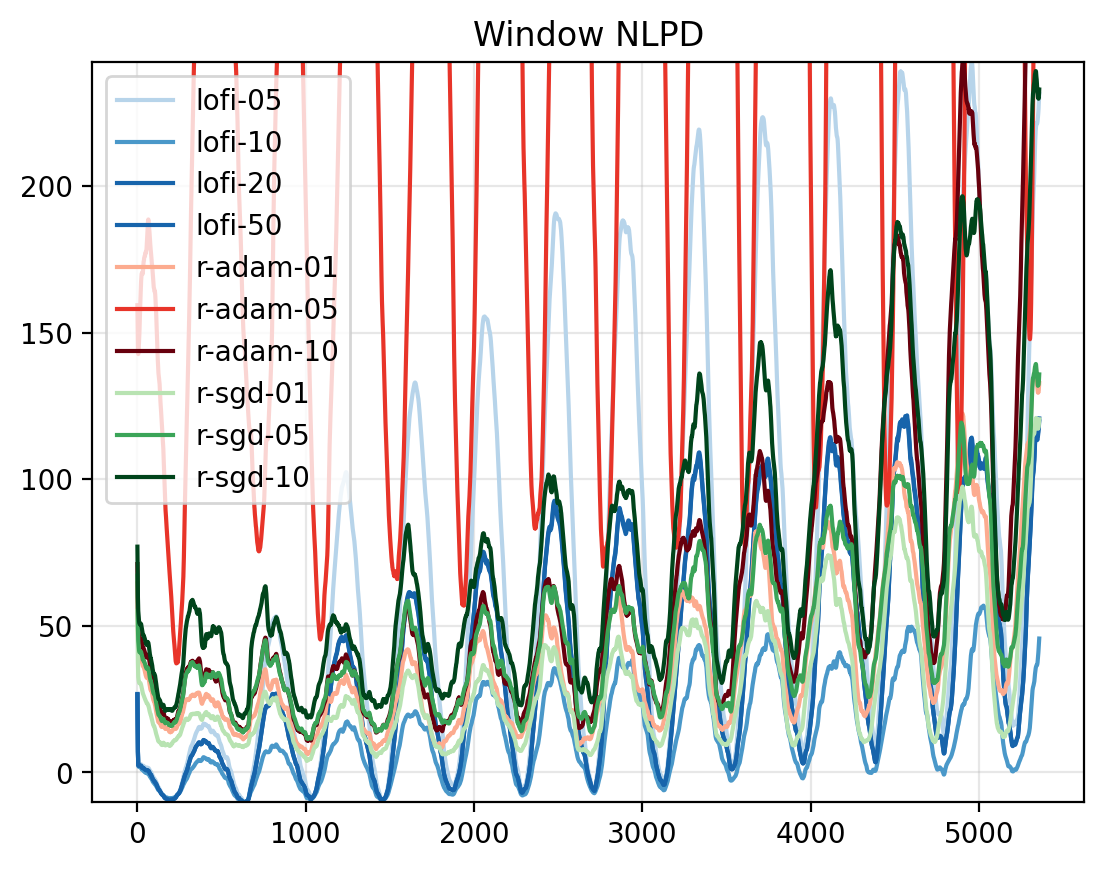

In [72]:
metric = "nlpd_window"
title = "Window NLPD"

outputs_metric = get_subtree(outputs, metric)
outputs_metric = jax.tree_map(lambda x: np.convolve(x, kernel, mode=kmode), outputs_metric)

for name_agent, metric_agent in outputs_metric.items():
    plt.plot(metric_agent, label=name_agent, c=colors[name_agent])

metric_agent = outputs_metric["lofi-05"]
vmin = np.quantile(metric_agent, 0.00)
vmax = np.quantile(metric_agent, 1.0)
plt.ylim(vmin, vmax)

plt.title(title)
plt.legend()
plt.grid(alpha=0.3)

namefile = f"window-nlpd.pdf"
namefile = os.path.join(dir_output, f"{task_name}-{namefile}")
plt.savefig(namefile)

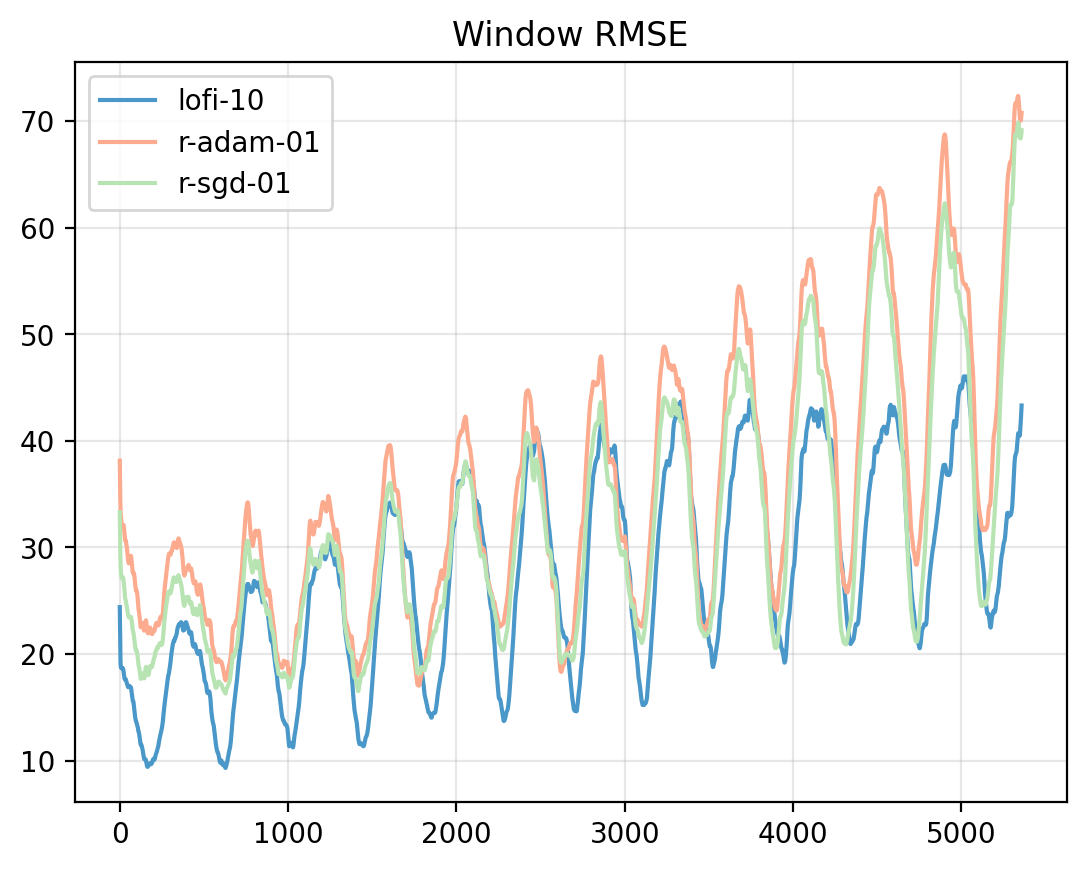

In [75]:
agents_targets = ["lofi-10", "r-adam-01", "r-sgd-01"]

metric = "window-metric"
title = "Window RMSE"

outputs_metric = get_subtree(outputs, metric)
outputs_metric = jax.tree_map(lambda x: np.convolve(x, kernel, mode=kmode), outputs_metric)

for name_agent in agents_targets:
    metric_agent = outputs_metric[name_agent]
    plt.plot(metric_agent, label=name_agent, color=colors[name_agent])


plt.title(title)
plt.legend()
plt.grid(alpha=0.3)


namefile = f"window-nlpd-best.pdf"
namefile = os.path.join(dir_output, f"{task_name}-{namefile}")
plt.savefig(namefile)